In [2]:
import os, json, random, cv2
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt

In [3]:
def check_samples(OUT_DIR):

    imgs = []
    labels = []

    for cls in sorted(os.listdir(OUT_DIR)):

        files = glob.glob(os.path.join(OUT_DIR, cls, "*.jpg"))

        if not files:
            continue

        img = cv2.cvtColor(cv2.imread(files[0]), cv2.COLOR_BGR2RGB)

        imgs.append(img)
        labels.append(cls)


    n = len(imgs)
    cols = min(5, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(3 * cols, 3 * rows))

    for i, (img, lbl) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(lbl, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Dark/Bright Samples

In [4]:
COCO_JSON = "/home/gridsan/manderson/ovdsat/data/mar/mar_coco_all.json"
IMAGE_DIR = "/home/gridsan/manderson/ovdsat/data/mar/JPEGImages"

In [8]:
MAX_GAIN = 2.2
MIN_GAIN = 1.2

IN_DIR = "/home/gridsan/manderson/ovdsat/data/cropped_data/mar/train/mar_N1-1"
OUT_DIR = "/home/gridsan/manderson/ovdsat/data/cropped_data/mar/train/mar_N1-1-bright-test"

os.makedirs(OUT_DIR, exist_ok=True)

for cls in os.listdir(IN_DIR):

    in_cls = os.path.join(IN_DIR, cls)
    out_cls = os.path.join(OUT_DIR, cls)

    if not os.path.isdir(in_cls):
        continue

    os.makedirs(out_cls, exist_ok=True)

    for name in os.listdir(in_cls):

        in_path = os.path.join(in_cls, name)
        out_path = os.path.join(out_cls, name)

        img = cv2.imread(in_path)
        if img is None:
            continue

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)

        mean_v = np.mean(hsv[:, :, 2]) / 255.0

        gain = MIN_GAIN + (MAX_GAIN - MIN_GAIN) * (1 - mean_v)

        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * gain, 0, 255)

        bright = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

        cv2.imwrite(out_path, bright)

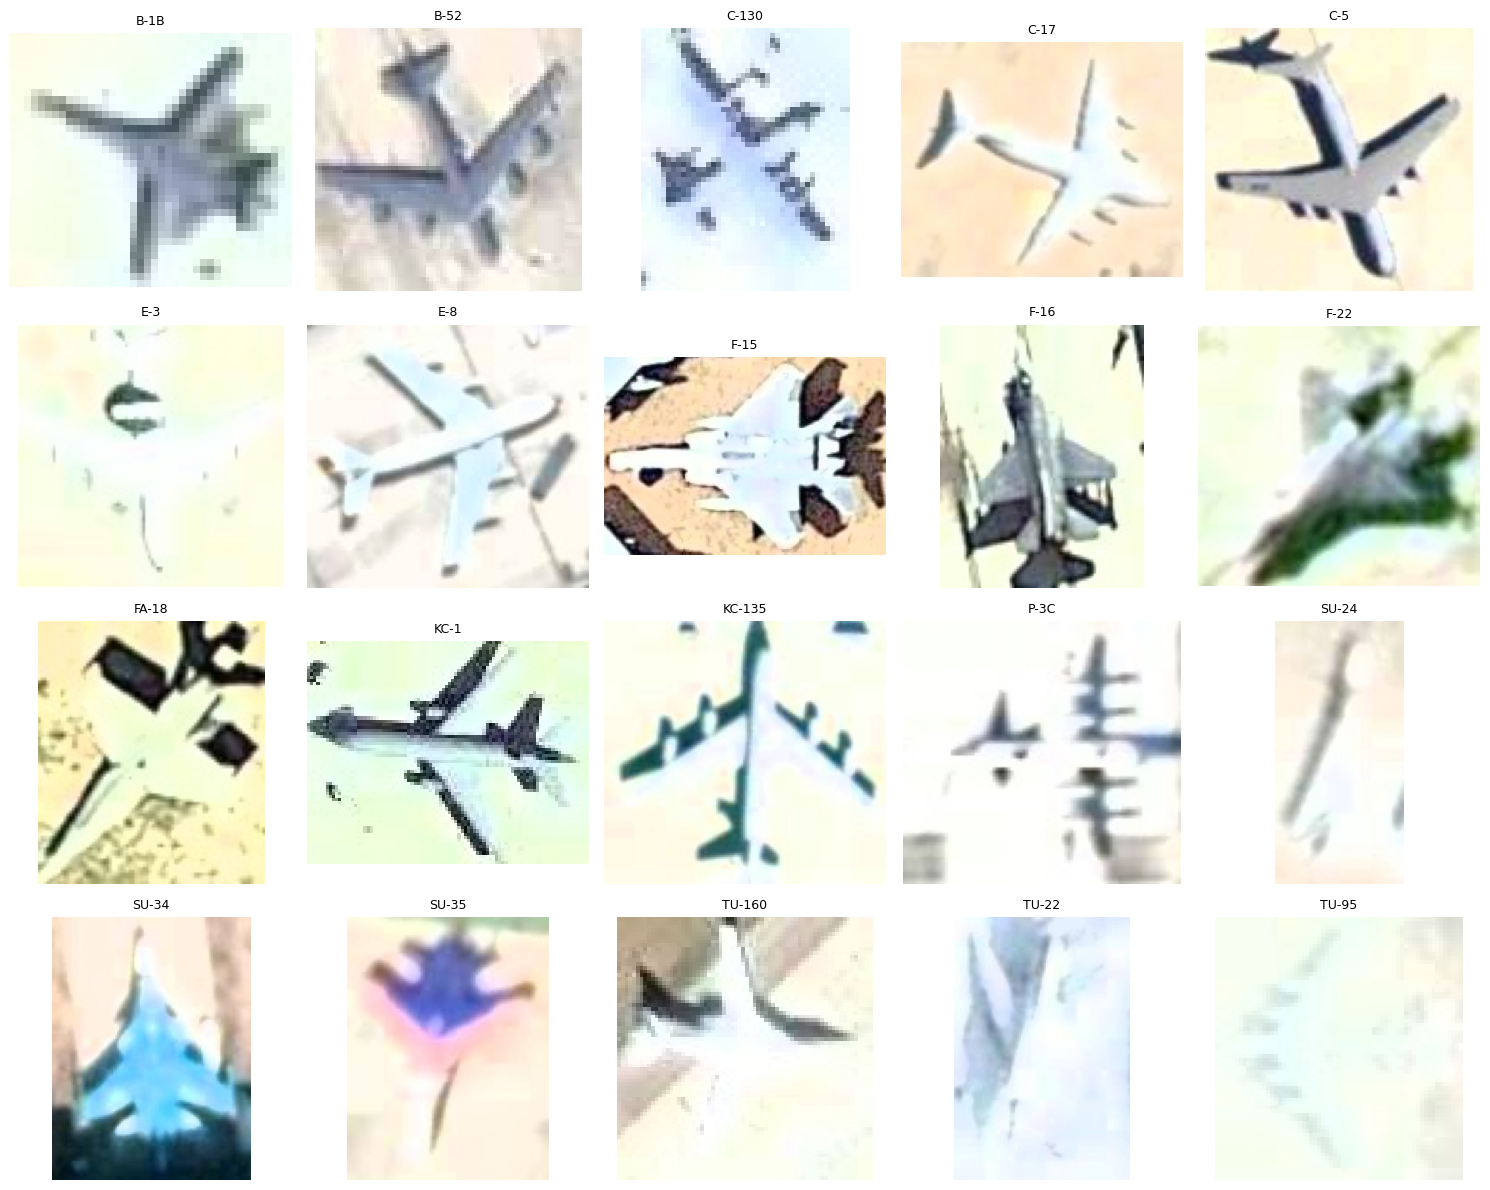

In [9]:
check_samples(OUT_DIR)

### OLD

In [6]:
# Bright
OUT_DIR = "/home/gridsan/manderson/ovdsat/data/cropped_data/mar/train/mar_N1-1-bright-test"

START_THRESHOLD = 240
MIN_THRESHOLD = 160
THRESH_STEP = 10

MAX_TRIES = 5000

os.makedirs(OUT_DIR, exist_ok=True)

with open(COCO_JSON) as f:
    coco = json.load(f)

images = {i["id"]: i["file_name"] for i in coco["images"]}
cats = {c["id"]: c["name"] for c in coco["categories"]}

by_class = defaultdict(list)
for a in coco["annotations"]:
    by_class[a["category_id"]].append(a)


def brightness(img):
    h, w = img.shape[:2]

    y1, y2 = h // 4, 3 * h // 4
    x1, x2 = w // 4, 3 * w // 4

    center = img[y1:y2, x1:x2]

    return np.mean(cv2.cvtColor(center, cv2.COLOR_BGR2HSV)[:, :, 2])


for cid, anns in by_class.items():

    cname = cats[cid]
    save_dir = os.path.join(OUT_DIR, cname)
    os.makedirs(save_dir, exist_ok=True)

    threshold = START_THRESHOLD
    found = False

    while threshold >= MIN_THRESHOLD and not found:

        print(f"{cname}: trying threshold {threshold}")

        for _ in tqdm(range(MAX_TRIES)):

            ann = random.choice(anns)
            img_path = os.path.join(IMAGE_DIR, images[ann["image_id"]])

            img = cv2.imread(img_path)
            if img is None:
                continue

            x, y, w, h = map(int, ann["bbox"])
            crop = img[y:y+h, x:x+w]

            if crop.size == 0:
                continue

            if brightness(crop) >= threshold:

                out_name = f"{ann['image_id']}_{ann['id']}.jpg"
                out_path = os.path.join(save_dir, out_name)

                cv2.imwrite(out_path, crop)

                print(f"{cname}: saved {out_name} @ {threshold}")
                found = True
                break

        threshold -= THRESH_STEP

    if not found:
        print(f"{cname}: no bright sample found!")

C-17: trying threshold 240


  1%|          | 53/5000 [00:03<04:58, 16.56it/s]


KeyboardInterrupt: 

In [ ]:
# Dark
OUT_DIR = "/home/gridsan/manderson/ovdsat/data/cropped_data/mar/train/mar_N1-dark"

START_THRESHOLD = 50
MAX_THRESHOLD = 100
THRESH_STEP = 10

MAX_TRIES = 2000

os.makedirs(OUT_DIR, exist_ok=True)

with open(COCO_JSON) as f:
    coco = json.load(f)

images = {i["id"]: i["file_name"] for i in coco["images"]}
cats = {c["id"]: c["name"] for c in coco["categories"]}

by_class = defaultdict(list)
for a in coco["annotations"]:
    by_class[a["category_id"]].append(a)


def brightness(img):
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 2])
#     h, w = img.shape[:2]

#     y1, y2 = h // 4, 3 * h // 4
#     x1, x2 = w // 4, 3 * w // 4

#     center = img[y1:y2, x1:x2]

#     return np.mean(cv2.cvtColor(center, cv2.COLOR_BGR2HSV)[:, :, 2])


for cid, anns in by_class.items():

    cname = cats[cid]
    save_dir = os.path.join(OUT_DIR, cname)
    os.makedirs(save_dir, exist_ok=True)

    threshold = START_THRESHOLD
    found = False

    while threshold <= MAX_THRESHOLD and not found:

        print(f"{cname}: trying threshold {threshold}")

        for _ in tqdm(range(MAX_TRIES)):

            ann = random.choice(anns)
            img_path = os.path.join(IMAGE_DIR, images[ann["image_id"]])

            img = cv2.imread(img_path)
            if img is None:
                continue

            x, y, w, h = map(int, ann["bbox"])
            crop = img[y:y+h, x:x+w]

            if crop.size == 0:
                continue

            if brightness(crop) <= threshold:

                out_name = f"{ann['image_id']}_{ann['id']}.jpg"
                out_path = os.path.join(save_dir, out_name)

                cv2.imwrite(out_path, crop)

                print(f"{cname}: saved {out_name} @ {threshold}")
                found = True
                break

        threshold += THRESH_STEP

    if not found:
        print(f"{cname}: no dark sample found")
